<a href="https://colab.research.google.com/github/SRI-2004/emotions_analyser/blob/main/emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognize emotions on one image with Python interface of EmotiEffLib

The first GPU device should be used for cuda

In [ ]:
%env CUDA_VISIBLE_DEVICES=0
try:
    import google.colab
    import urllib.request
    IN_COLAB = True
    urllib.request.urlretrieve("https://github.com/sb-ai-lab/EmotiEffLib/blob/main/docs/tutorials/python/requirements.txt?raw=true", "requirements.txt")
    !pip install -r requirements.txt
except:
    IN_COLAB = False

env: CUDA_VISIBLE_DEVICES=0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.7/455.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Function for faces recognition:

In [ ]:
from typing import List
import numpy as np

def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    """
    Detects faces in the given image and returns the facial images cropped from the original.

    This function reads an image from the specified path, detects faces using the MTCNN
    face detection model, and returns a list of cropped face images.

    Args:
        frame (numpy.ndarray): The image frame in which faces need to be detected.
        device (str): The device to run the MTCNN face detection model on, e.g., 'cpu' or 'cuda'.

    Returns:
        list: A list of numpy arrays, representing a cropped face image from the original image.

    Example:
        faces = recognize_faces('image.jpg', 'cuda')
        # faces contains the cropped face images detected in 'image.jpg'.
    """

    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        facial_images.append(frame[y1:y2, x1:x2, :])
    return facial_images

Check if it runs under colab and install dependencies:

In [ ]:
!pip install emotiefflib[torch]

Helper function to get path to the input image:

## EmotiEffLib with ONNX

Install EmotiEffLib with ONNX support:

Import libraries:

In [ ]:
import os
from typing import List

import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

Path to the test directory, select device and model:

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = get_model_list()[0]

def get_test_image():
    input_file = "blackswan2.png"
    return input_file

Open test image:

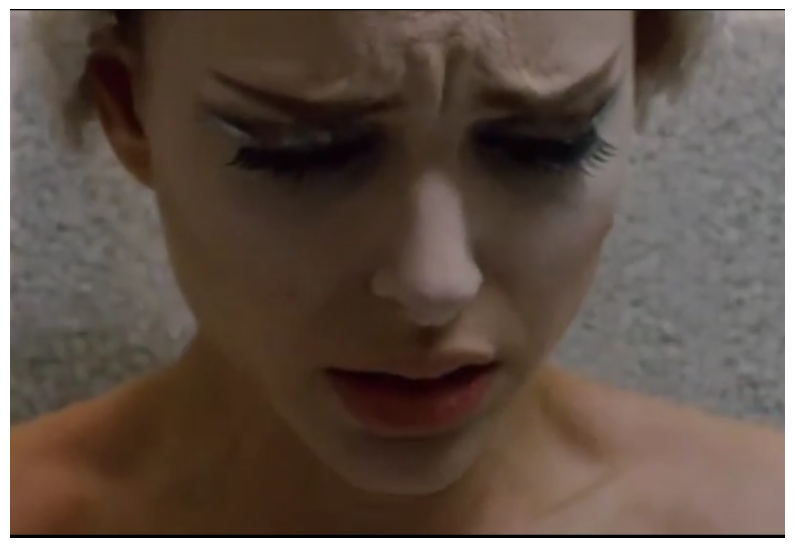

In [ ]:
input_file = get_test_image()
frame_bgr = cv2.imread(input_file)
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(frame)

### Recognize faces on the test image and detect emotions:

enet_b0_8_best_vgaf


Text(0.5, 1.0, 'Sadness')

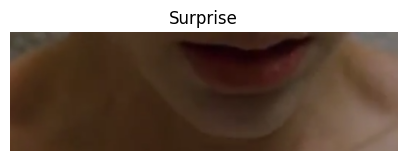

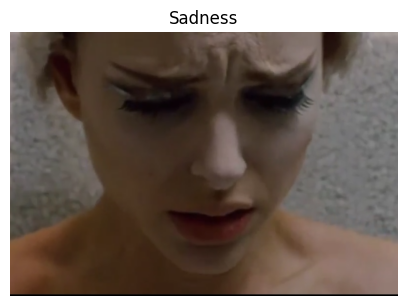

In [ ]:
facial_images = recognize_faces(frame, device)

fer = EmotiEffLibRecognizer(engine="torch", model_name=model_name, device=device)
print(model_name)
emotions = []
for face_img in facial_images:
  emotion, _ = fer.predict_emotions(face_img, logits=True)
  emotions.append(emotion[0])
  plt.figure(figsize=(5, 5))
  plt.axis('off')
  plt.imshow(face_img)
  plt.title(emotion[0])


emotion, _ = fer.predict_emotions(frame, logits=True)
emotions.append(emotion[0])
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(frame)
plt.title(emotion[0])


### Detect emotions on several facial images:

In [ ]:
multi_emotions, _ = fer.predict_emotions(facial_images, logits=True)
assert multi_emotions == emotions

### Detect emotions by calling features extractor and classifier separately

In [ ]:
features = fer.extract_features(facial_images)
classified_emotions, _ = fer.classify_emotions(features, logits=True)
assert classified_emotions == emotions